In [1]:
import pystare as ps

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cf

import numpy
import shapely

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import geopandas


In [2]:
# Some helper functions for plotting & printing.

class figax_container(object):
    def __init__(self,figax):
        self.fig = figax[0]
        self.ax  = figax[1]
        return

def add_coastlines(figax,set_global=False):
    "Add coastlines to the plot."
    ax = figax.ax
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def hello_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options={'projection':ccrs.PlateCarree(),'transform':ccrs.Geodetic()}
        ,set_global=False
        ,set_coastlines=True
        ,show=True
        ,color=None
        ,lw=1
        ):

    if figax is None:
        figax = figax_container(plt.subplots(1,subplot_kw=plot_options))
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()
    else:
        ax = figax.ax
    
    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        
        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons,lats,intmat)
        figax.ax.triplot(siv_triang,c=color,transform=plot_options['transform'],lw=lw)
    
    if show:
        plt.show()
        
    return figax

def hex16(i):
    return "0x%016x"%i

def lonlat_from_coords(coords):
    tmp = numpy.array(coords)
    lat=tmp[:,1]
    lon=tmp[:,0]
    return lon,lat

km  = 1 # Unit of length
deg = 1 # Unit of angle

In [3]:
# Set up the projection and transformation
proj         = ccrs.PlateCarree()
# proj        = ccrs.Robinson() # Drives matplotlib bug.
# proj        = ccrs.Mollweide() # Drives matplotlib bug.
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5*default_dpi

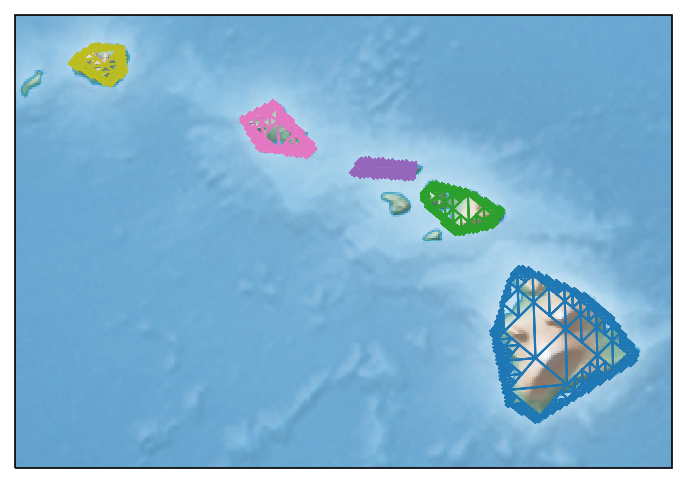

In [4]:
# Make covers from shapely polygons using convex hulls

cover_resolution = 12

figax = hello_plot(set_coastlines=False,set_global=False,show=False)  
        
lines = list(cf.COASTLINE.geometries())[107:112]

multiline = shapely.geometry.MultiLineString(lines)
# figax.ax.add_geometries(multiline,cf.COASTLINE.crs,color='c',alpha=0.5)
# figax.ax.set_extent(numpy.array(multiline.bounds)[[0,2,1,3]])

lons,lats = lonlat_from_coords(list(lines[0].coords))

covers = []
for k in range(len(lines)):
    # lons,lats = lonlat_from_coords(list(lines[k].coords))
    covers = covers + [ps.from_polygon(shapely.geometry.Polygon(lines[k]),resolution=cover_resolution
                                       ,nonconvex=False)]
    
    # Default Cartopy background imagery
    # figax.ax.stock_img()

    # For an example of how to add imagery for background_img, see extras/05-FetchNaturalEarth-1.
    # figax.ax.background_img(name='ne_shaded') # Identical to stock_img.
    # figax.ax.background_img(name='ne1_50m_sr_w')
    # figax.ax.background_img(name='ne1_10m_sr_w_dr')
    # figax.ax.background_img(name='hypso_50m_sr_w')
    figax.ax.background_img(name='hypso_10m_sr_w_ob_dr')
    
    # figax = hello_plot(ps.expand_intervals(covers[k],8),figax,show=False)
    figax = hello_plot(covers[k],figax,show=False)
                      
figax.ax.set_extent(numpy.array([-160.3, 18.5, -154.5, 22.5])[[0,2,1,3]])

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.

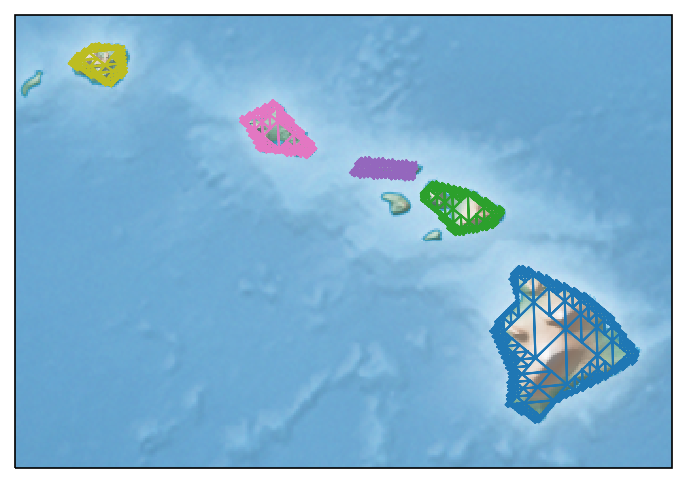

In [5]:
# Make covers from shapely polygons using non-convex hulls

figax = hello_plot(set_coastlines=False,set_global=False,show=False)  
        
lines = list(cf.COASTLINE.geometries())[107:112]
multiline = shapely.geometry.MultiLineString(lines)
# figax.ax.add_geometries(multiline,cf.COASTLINE.crs,color='c',alpha=0.5)
# figax.ax.set_extent(numpy.array(multiline.bounds)[[0,2,1,3]])

# lons,lats = lonlat_from_coords(list(lines[0].coords))

covers = []
for k in range(len(lines)):
#    lons,lats = lonlat_from_coords(list(lines[k].coords))
    covers = covers + [ps.from_polygon(shapely.geometry.polygon.orient(shapely.geometry.Polygon(lines[k]),1)
                                       ,resolution=cover_resolution,nonconvex=True)]
#    covers = covers + [ps.to_nonconvex_hull_range_from_latlon(lats,lons,resolution=10)]
#    covers = covers + [ps.to_hull_range_from_latlon(lats,lons,resolution=10)]

    # Default Cartopy background imagery
    # figax.ax.stock_img()

    # For an example of how to add imagery for background_img, see extras/05-FetchNaturalEarth-1.
    figax.ax.background_img(name='ne_shaded') # Identical to stock_img.
    # figax.ax.background_img(name='ne1_50m_sr_w')
    # figax.ax.background_img(name='ne1_10m_sr_w_dr')
    # figax.ax.background_img(name='hypso_50m_sr_w')
    figax.ax.background_img(name='hypso_10m_sr_w_ob_dr')
    
    # figax = hello_plot(ps.expand_intervals(covers[k],8),figax,show=False)
    figax = hello_plot(covers[k],figax,show=False)
                      
figax.ax.set_extent(numpy.array([-160.3, 18.5, -154.5, 22.5])[[0,2,1,3]])

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.

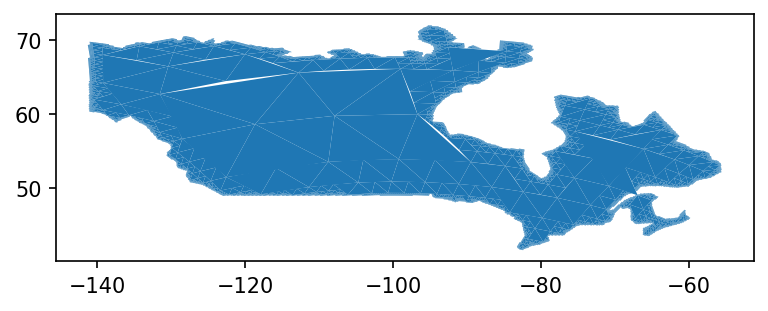

In [6]:
# Now let's try some Geopandas and Canada
polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
country = polygons[polygons.name =='Canada'].iloc[0].geometry[0]
ids = ps.from_polygon(shapely.geometry.polygon.orient(country,1), resolution=10, nonconvex=True)
geoms = ps.to_trixels(ids)
gdf = geopandas.GeoDataFrame({'geom':geoms}).set_geometry('geom').plot()

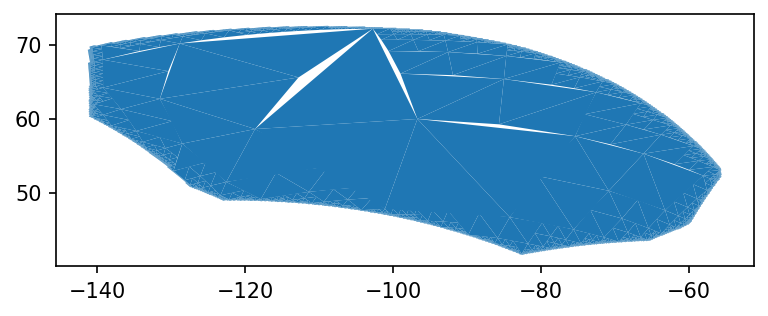

In [7]:
# Now let's try some Geopandas and Canada, and for comparison, a convex hull.
polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
country = polygons[polygons.name =='Canada'].iloc[0].geometry[0]
ids = ps.from_polygon(country, resolution=10, nonconvex=False)
geoms = ps.to_trixels(ids)
gdf = geopandas.GeoDataFrame({'geom':geoms}).set_geometry('geom').plot()

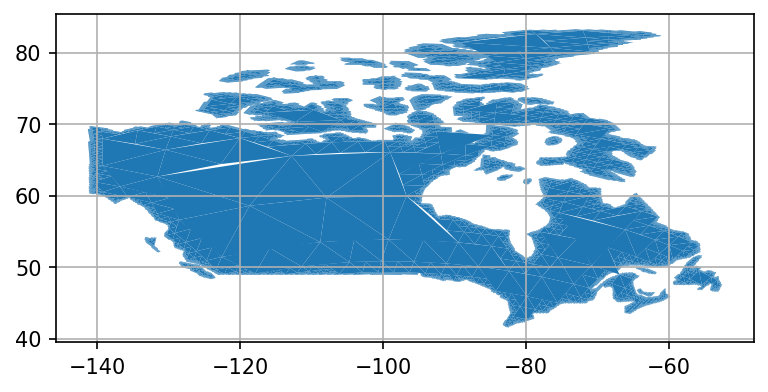

In [8]:
polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
country = polygons[polygons.name =='Canada']

ids = ps.from_geopandas(country, resolution=10, nonconvex=True, force_orientation=1)
trixels = ps.to_trixels_series(ids)
country = country.assign(trixels=trixels)

fig, ax = plt.subplots()
ax.grid(True)

country.set_geometry('trixels', inplace=True)
country.plot(ax=ax)